<a href="https://colab.research.google.com/github/TAEWOOYOON/SkillTreePython-DeepLearning/blob/main/03.NLP-with-tensorflow2.0/ch03_04_%EC%88%9C%ED%99%98%EC%8B%A0%EA%B2%BD%EB%A7%9D_Bidirectional_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ch03.04_순환신경망 - Bidirectional-LSTM
---

* 날짜: 2022.07.18
* 이름: 윤태우


## 학습내용
    - 순환 신경망에 대해 이해한다.
    - BiLSTM
    - 로이터 뉴스기사 카테고리 분류
    - 스팀 리뷰 걈성 분류

```
! git clone https://github.com/yebiny/SkillTreePython-DeepLearning
```

```
import sys
sys.path.append('/content/SkillTreePython-DeepLearning/scripts')
from import_lib import *
from plot_result import *
```

In [ ]:
! git clone https://github.com/yebiny/SkillTreePython-DeepLearning

fatal: destination path 'SkillTreePython-DeepLearning' already exists and is not an empty directory.


In [ ]:
import sys
sys.path.append('/content/SkillTreePython-DeepLearning/scripts')
from import_lib import *
from plot_result import *

## 로이터 뉴스 기사 분류
---

### | 데이터 전처리 

#### **데이터 불러오기**

In [ ]:
MAX_FEATURES = 1000 # 데이터에 1000(-1)개 단어만 포함하기
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.reuters.load_data(num_words=MAX_FEATURES)
print('훈련데이터 : ',x_train.shape, y_train.shape)
print('테스트 데이터 : ',x_test.shape, y_test.shape)

훈련데이터 :  (8982,) (8982,)
테스트 데이터 :  (2246,) (2246,)


#### **데이터 확인**

In [ ]:
print('첫번째 기사 : ', x_train[0]) # 토큰화, 단어 인덱싱이 된 상태
print('첫번째 기사의 카테고리 : ', y_train[0])
print('카테고리의 개수 : ', np.max(y_train)+1) # 클래스가 0~45

첫번째 기사 :  [1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 2, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 2, 2, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 2, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
첫번째 기사의 카테고리 :  3
카테고리의 개수 :  46


뉴스 기사의 평균길이 :  145.5398574927633


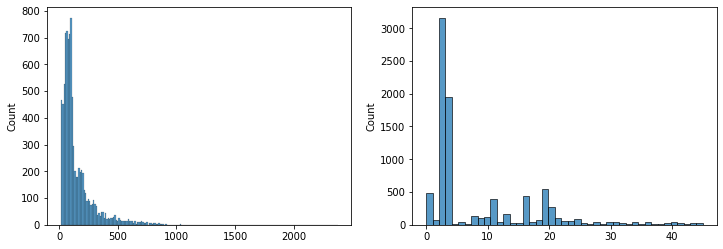

In [ ]:
# 뉴스 기사의 평균 단어 길이
plt.figure(figsize = (12,4))
len_sample = [len(x) for x in x_train]
plt.subplot(121);sns.histplot(x=len_sample)
plt.subplot(122);sns.histplot(x=y_train)
print('뉴스 기사의 평균길이 : ', np.mean(len_sample))

In [ ]:
# 데이터 전처리
MAX_LEN = 128
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen = MAX_LEN)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen = MAX_LEN)
print('훈련데이터 : ',x_train.shape, y_train.shape)
print('테스트 데이터 : ',x_test.shape, y_test.shape)

훈련데이터 :  (8982, 128) (8982,)
테스트 데이터 :  (2246, 128) (2246,)


In [ ]:
x_train[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   1,   2,   2,   8,  43,  10, 447,   5,  25, 207, 270,
         5,   2, 111,  16, 369, 186,  90,  67,   7,  89,   5,  19, 102,
         6,  19, 124,  15,  90,  67,  84,  22, 482,  26,   7,  48,   4,
        49,   8, 864,  39, 209, 154,   6, 151,   6,  83,  11,  15,  22,
       155,  11,  15,   7,  48,   9,   2,   2, 504,   6, 258,   6, 272,
        11,  15,  22, 134,  44,  11,  15,  16,   8, 197,   2,  90,  67,
        52,  29, 209,  30,  32, 132,   6, 109,  15,  17,  12], dtype=int32)

### | 임베딩 매트릭스 제작

```
! gdown https://drive.google.com/u/0/uc?id=1ams5_zp8NrfmbxSzTDCglRpAvjFGi5JY&export=download
! unzip  /content/glove.6B.zip
```


In [ ]:
! gdown https://drive.google.com/u/0/uc?id=1SskmaqNEYmXSADf3opvqoova08078lJV&export=download

Downloading...
From: https://drive.google.com/u/0/uc?id=1SskmaqNEYmXSADf3opvqoova08078lJV
To: /content/glove.6B.100d.txt
100% 347M/347M [00:01<00:00, 311MB/s]


#### **단어-임베딩 딕셔너리**

```
embeddings_index = {}
f = open('glove.6B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
```

#### **인덱싱-단어 딕셔너리**

In [ ]:
print(word2index)
index2word = {}
for word, index in word2index.items() :
  index2word[index] = word

#### **매트릭스 제작**

In [ ]:
embeddings_index = {}
f = open('glove.6B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [ ]:
EMB_DIMS=100
embedding_matrix = np.zeros((MAX_FEATURES, EMB_DIMS))
print('임베딩 매트릭스 (W): ' , embedding_matrix.shape)
for i in range(1, MAX_FEATURES):
  idx=i+4
  word = index2word.get(idx)
  vec = embeddings_index.get(word)
  if vec is not None:
    embedding_matrix[i]=vec
    #print(i, idx, word, vec)


임베딩 매트릭스 (W):  (1000, 100)


### | 모델학습 1

이때까지 배운 레이어를 사용하여 모델을 구축하세요.

```
Embedding()
RNN()
LSTM()
GRU()
GlobalAveragePooling1D()
Dense()
```

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 128)]             0         
                                                                 
 embedding_24 (Embedding)    (None, 128, 100)          100000    
                                                                 
 gru_24 (GRU)                (None, 128, 64)           31872     
                                                                 
 lstm_16 (LSTM)              (None, 128, 64)           33024     
                                                                 
 global_average_pooling1d_6   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_16 (Dense)            (None, 46)                2990      
                                                          

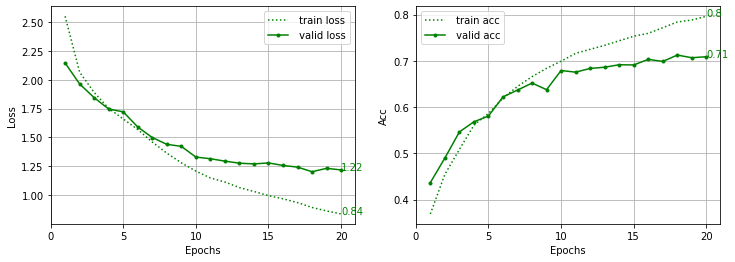

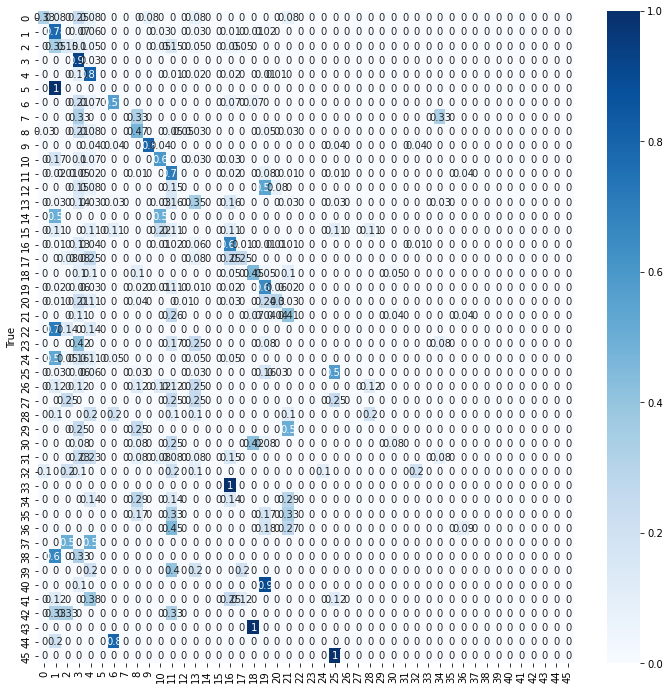

In [ ]:
EMB_DIMS = 100
x = layers.Input(shape = MAX_LEN)
y = layers.Embedding(MAX_FEATURES, EMB_DIMS)(x)
y = layers.GRU(64, return_sequences = True)(y)
y = layers.LSTM(64,dropout=0.3, return_sequences = True)(y)
y = layers.GlobalAveragePooling1D()(y)
y = layers.Dense(46, activation = 'softmax')(y)
model = models.Model(x,y)

model.layers[1].set_weights([embedding_matrix])
model.compile(loss = 'sparse_categorical_crossentropy', 
              optimizer = 'adam', 
              metrics = ['acc'])
model.summary()
history = model.fit(x_train, y_train,
                    batch_size = 126, 
                    epochs = 20,
                    validation_data = (x_test, y_test))

plot_lcurve([history], [''], ['g'], x_itv = 5)
draw_cm(model, x_test, y_test)

### | 모델학습 2

![](https://www.researchgate.net/profile/Arvind-Mohan-3/publication/324769532/figure/fig2/AS:619510805561344@1524714294669/LSTM-and-BiLSTM-Architectures.png)

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_29 (InputLayer)       [(None, 128)]             0         
                                                                 
 embedding_25 (Embedding)    (None, 128, 100)          100000    
                                                                 
 bidirectional_2 (Bidirectio  (None, 128, 128)         63744     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 128, 128)         74496     
 nal)                                                            
                                                                 
 global_average_pooling1d_7   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                          

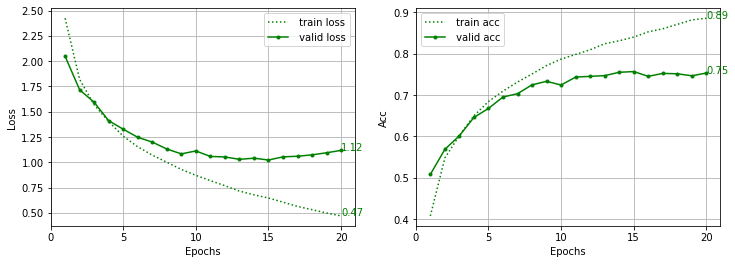

In [ ]:
x = layers.Input(shape = MAX_LEN)
y = layers.Embedding(MAX_FEATURES, EMB_DIMS)(x)
y = layers.Bidirectional(layers.GRU(64, return_sequences = True))(y)
y = layers.Bidirectional(layers.GRU(64, return_sequences = True))(y)
y = layers.GlobalAveragePooling1D()(y)
y = layers.Dense(46, activation = 'softmax')(y)
model = models.Model(x,y)

model.layers[1].set_weights([embedding_matrix])
model.compile(loss = 'sparse_categorical_crossentropy', 
              optimizer = 'adam', 
              metrics = ['acc'])
model.summary()
history = model.fit(x_train, y_train,
                    batch_size = 126, 
                    epochs = 20,
                    validation_data = (x_test, y_test))

plot_lcurve([history], [''], ['g'], x_itv = 5)

## 스팀 리뷰 감성 분류
---

https://wikidocs.net/94748

```
# Colab에 Mecab 설치
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh
```

In [ ]:
# Colab에 Mecab 설치
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 115 (delta 11), reused 10 (delta 3), pack-reused 91
Receiving objects: 100% (115/115), 1.27 MiB | 28.28 MiB/s, done.
Resolving deltas: 100% (50/50), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 688 kB/s 
     |████████████████████████████████| 453 kB 74.3 MB/s 
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2022-07-18 01:30:36--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::22c5:2ef4, 2406:da00:ff00::22e9:9f55, ...
Connecting to bitbucket.org (b

In [ ]:
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd

In [ ]:
# 해당 URL에서 데이터 불러오기
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/steam.txt", filename="steam.txt")

('steam.txt', <http.client.HTTPMessage at 0x7fcc37be7810>)

In [ ]:
# 데이터에 컬럼명이 따로 존재하지 않으므로 컬럼 설정
total_data = pd.read_table('steam.txt', names=['label', 'reviews'])
print('전체 리뷰 개수 :',len(total_data)) # 전체 리뷰 개수 출력

전체 리뷰 개수 : 100000


In [ ]:
# 상위 5개 리뷰 확인
total_data[:5]

,label,reviews
0,0,노래가 너무 적음
1,0,"돌겠네 진짜. 황숙아, 어크 공장 그만 돌려라. 죽는다."
2,1,막노동 체험판 막노동 하는사람인데 장비를 내가 사야돼 뭐지
3,1,차악!차악!!차악!!! 정말 이래서 왕국을 되찾을 수 있는거야??
4,1,시간 때우기에 좋음.. 도전과제는 50시간이면 다 깰 수 있어요


In [ ]:
# 전체 데이터에서 중복되는 것을 제외한 샘플 수
total_data['reviews'].nunique(), total_data['label'].nunique()

(99892, 2)

In [ ]:
# 중복되는 샘플이 존재하므로 제거
total_data.drop_duplicates(subset=['reviews'], inplace=True) # reviews 열에서 중복인 내용이 있다면 중복 제거
print('총 샘플의 수 :',len(total_data))

총 샘플의 수 : 99892


In [ ]:
total_data.isnull().sum() # null값 확인

label      0
reviews    0
dtype: int64

In [ ]:
# train, test 데이터 분할
train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42)
print(len(train_data), len(test_data))

74919 24973


   label  count
0      0  37376
1      1  37543


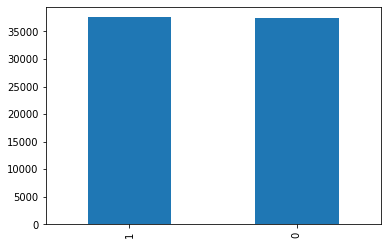

In [ ]:
# label 분포 확인
train_data['label'].value_counts().plot(kind = 'bar')
print(train_data.groupby('label').size().reset_index(name = 'count'))

In [ ]:
# 한글과 공백을 제외하고 모두 제거
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 
test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

label      0
reviews    0
dtype: int64
전처리 후 테스트용 샘플의 개수 : 24973


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """


In [ ]:
# 형태소 같은것들을 불용어로 정의 
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게', '만', '게임', '겜', '되', '음', '면']

In [ ]:
# stopwords에 정의되지 않은 용어들을 train, test 데이터 'tokenized' 컬럼에 추가
mecab = Mecab() 

train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [ ]:
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

In [ ]:
# 부정리뷰에서 빈도수가 가장 높은 글자 출력
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

[('안', 8129), ('없', 7141), ('는데', 5786), ('있', 5692), ('같', 4247), ('로', 4083), ('할', 3920), ('거', 3902), ('나', 3805), ('해', 3653), ('너무', 3522), ('으로', 3351), ('기', 3348), ('했', 3265), ('어', 3143), ('보', 2987), ('습니다', 2962), ('것', 2935), ('지만', 2911), ('좋', 2899)]


In [ ]:
# 긍정리뷰에서 빈도수가 가장 높은 글자 출력
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[('있', 9987), ('좋', 6542), ('습니다', 5179), ('재밌', 4997), ('할', 4838), ('지만', 4809), ('해', 4354), ('없', 4145), ('보', 3907), ('으로', 3900), ('로', 3879), ('수', 3835), ('는데', 3825), ('기', 3592), ('안', 3368), ('것', 3362), ('같', 3356), ('네요', 3189), ('어', 3112), ('나', 3055)]


긍정 리뷰의 평균 길이 : 14.948459100231734
부정 리뷰의 평균 길이 : 15.284193065068493


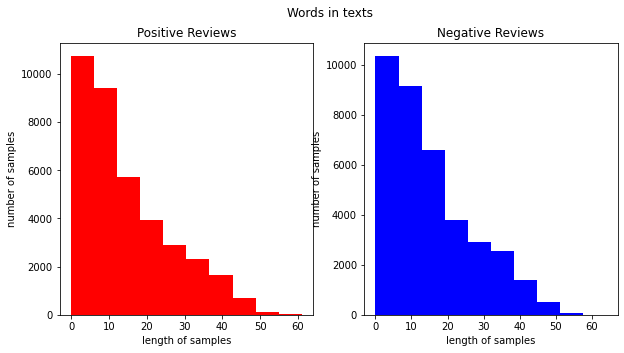

In [ ]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

In [ ]:
# train, test셋 분리
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
# 빈도수가 2개 미만인 형태소들은 배제

threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 32817
등장 빈도가 1번 이하인 희귀 단어의 수: 13878
단어 집합에서 희귀 단어의 비율: 42.28905750068562
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.2254607619437832


In [ ]:
# 전체 빈도에서 희귀 단어 빈도가 1.2% 밖에 되지 않으므로 중요하지 않다는 판단, 자연어 처리에서 배제

In [ ]:
# 전체 형태소에서 빈도수 2이하인 형태소 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 18941


In [ ]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV')  # OOV : 단어 사전에 없는 용어 -> OOV로 변환 했다는 것은 인식 하지 않겠다는 뜻
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

리뷰의 최대 길이 : 64
리뷰의 평균 길이 : 15.115951894712957


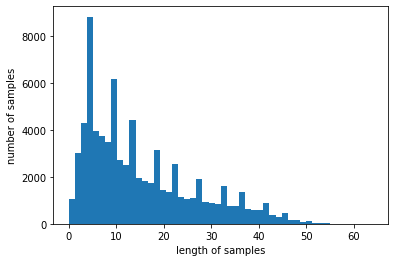

In [ ]:
# 리뷰의 최대길이. 평균길이 시각화
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
# 최대 길이가 64 이하인 리뷰들이다. 함수를 생성해서 최대길이를 설정하면 그 길이 이하의 리뷰 비율을 나타내도록 한다.
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [ ]:
# 최대길이 60으로 제한했을 때 샘플의 비율 
max_len = 60
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 60 이하인 샘플의 비율: 99.99599567532935


In [ ]:
# 길이 60 이하인 샘플이 99.9% 이므로 60이하의 리뷰들을 패딩 한다.
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_39 (InputLayer)       [(None, 60)]              0         
                                                                 
 embedding_34 (Embedding)    (None, 60, 100)           1894100   
                                                                 
 bidirectional_17 (Bidirecti  (None, 60, 256)          176640    
 onal)                                                           
                                                                 
 global_average_pooling1d_12  (None, 256)              0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_23 (Dense)            (None, 1)                 257       
                                                                 
Total params: 2,070,997
Trainable params: 2,070,997
Non-tr

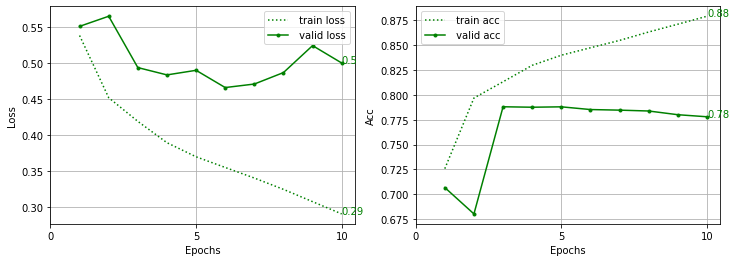

In [ ]:
import re
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

x = layers.Input(shape = (60))
y = layers.Embedding(vocab_size, embedding_dim)(x)
y = Bidirectional(layers.GRU(hidden_units, return_sequences = True))(y)
y = layers.GlobalAveragePooling1D()(y)
y = layers.Dense(1, activation = 'sigmoid')(y)
model = models.Model(x,y)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()
history = model.fit(X_train, y_train, 
                    epochs=15, callbacks=[es, mc], 
                    batch_size=256, validation_split=0.2)

plot_lcurve([history], [''], ['g'], x_itv = 5)

In [ ]:
loaded_model = load_model('best_model.h5')
print("테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

781/781 [==============================] - 5s 5ms/step - loss: 0.4970 - acc: 0.7846
테스트 정확도: 0.7846


In [ ]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = mecab.morphs(new_sentence) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [ ]:
sentiment_predict('짜증나네')

89.13% 확률로 부정 리뷰입니다.


In [ ]:
sentiment_predict('왜그런진 모르겠지만 재밌음')

94.89% 확률로 긍정 리뷰입니다.


In [ ]:
sentiment_predict('정신차리고 보니 시간이 훅 가있었다')

93.81% 확률로 긍정 리뷰입니다.
